## Data Preprocessing Analysis - Hotel Booking Cancellation Prediction

1. **Environment Setup & Data Loading** - Load and validate dataset
2. **Data Quality Assessment** - Missing values and business logic checks
3. **Missing Value Treatment** - Simple mean/mode imputation strategy
4. **Outlier Treatment** - IQR method with capping (preserve data)
5. **Final Data Preparation** - Remove leakage, encode categories, add EDA features

**Key Focus:** EDA-driven feature engineering based on lead_time analysis (0.293 correlation with cancellation)

## ? Phase 1: Environment Setup & Data Loading

In [54]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import sys
import os
sys.path.append('../scripts')
from preprocessing import HotelDataPreprocessor

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

### ? Data Loading & Initial Validation

In [55]:
# Initialize preprocessor and load data
preprocessor = HotelDataPreprocessor()
start_time = datetime.now()

# Load the raw data
df = preprocessor.load_data('../data/raw/hotel_booking.csv')

# Initial dataset overview
print(f"\nDataset Overview:")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
print(f"Cancellation rate: {df['is_canceled'].mean():.3f} ({df['is_canceled'].sum():,} cancellations)")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Quick data types summary
print(f"\nColumn Types:")
print(f"Numerical: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical: {len(df.select_dtypes(include=['object']).columns)}")
print(f"Date columns: {len([col for col in df.columns if 'date' in col.lower()])}")

# Display first few rows
print(f"\nFirst 3 rows:")
display(df.head(3))

INFO:preprocessing:Data loaded: 119,390 rows, 36 columns



Dataset Overview:
Shape: 119,390 rows × 36 columns
Cancellation rate: 0.370 (44,224 cancellations)
Memory usage: 123.45 MB

Column Types:
Numerical: 20
Categorical: 16
Date columns: 5

First 3 rows:


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734


## ? Phase 2: Data Quality Assessment

**Essential Checks Only:**
- Missing value analysis (identify patterns)
- Business logic validation (data leakage, impossible values)

INFO:preprocessing:Assessing data quality...
INFO:preprocessing:Missing: children - 4 (0.0%)
INFO:preprocessing:Missing: country - 488 (0.4%)
INFO:preprocessing:Missing: agent - 16,340 (13.7%)
INFO:preprocessing:Missing: company - 112,593 (94.3%)
INFO:preprocessing:Missing: children - 4 (0.0%)
INFO:preprocessing:Missing: country - 488 (0.4%)
INFO:preprocessing:Missing: agent - 16,340 (13.7%)
INFO:preprocessing:Missing: company - 112,593 (94.3%)


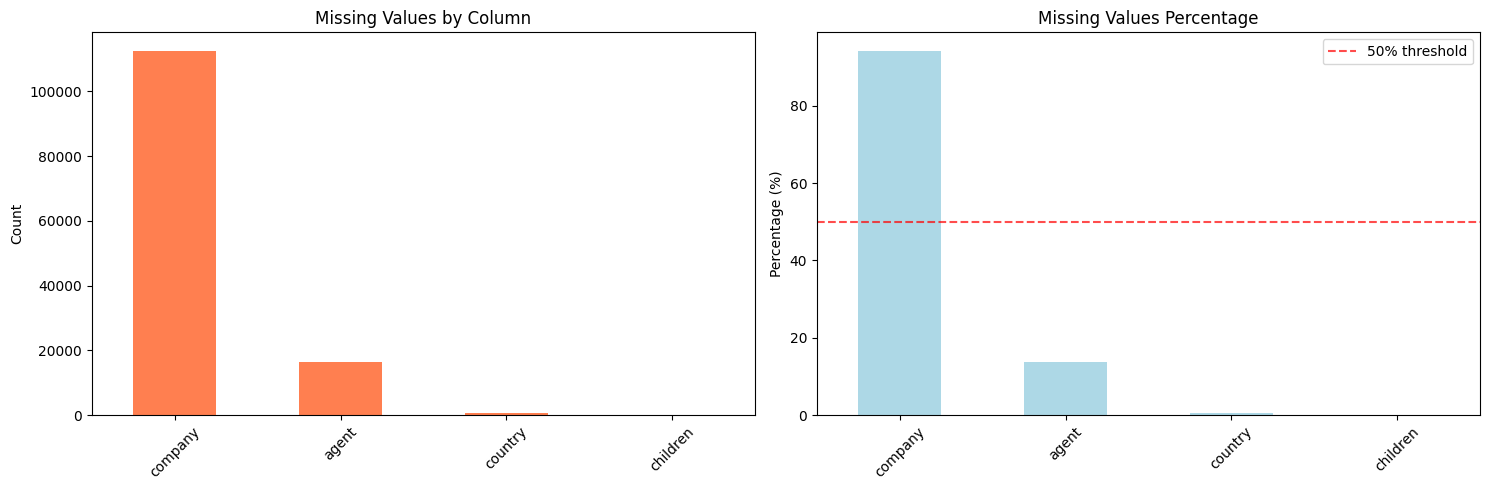

Data quality assessment complete


In [56]:
# Phase 2: Data Quality Assessment
quality_report = preprocessor.assess_data_quality(df)

# Visualize missing values
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Missing value counts
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if len(missing_data) > 0:
    # Bar plot of missing values
    missing_data.plot(kind='bar', ax=axes[0], color='coral')
    axes[0].set_title('Missing Values by Column')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Missing value percentages
    missing_pct = (missing_data / len(df)) * 100
    missing_pct.plot(kind='bar', ax=axes[1], color='lightblue')
    axes[1].set_title('Missing Values Percentage')
    axes[1].set_ylabel('Percentage (%)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
    axes[1].legend()
else:
    axes[0].text(0.5, 0.5, 'No Missing Values Found', ha='center', va='center', transform=axes[0].transAxes, fontsize=14)
    axes[1].text(0.5, 0.5, 'No Missing Values Found', ha='center', va='center', transform=axes[1].transAxes, fontsize=14)

plt.tight_layout()
plt.show()

print(f"Data quality assessment complete")

### Handle missing values

## ? Phase 3: Missing Value Treatment

**Simple Strategy:**
- Drop columns with >50% missing (if any)
- Numerical: Mean imputation
- Categorical: Mode imputation

In [57]:
# Phase 3: Handle missing values
print("Phase 3: Missing Value Treatment")
missing_before = df.isnull().sum().sum()

df_clean = preprocessor.handle_missing_values(df)

missing_after = df_clean.isnull().sum().sum()
print(f"Missing values: {missing_before} → {missing_after}")
print(f"Shape maintained: {df_clean.shape}")

# Quick validation
print(f"Missing value treatment complete")
print(f"All missing values handled: {df_clean.isnull().sum().sum() == 0}")

INFO:preprocessing:Handling missing values...
INFO:preprocessing:Dropped company (>50% missing)
INFO:preprocessing:Dropped company (>50% missing)


Phase 3: Missing Value Treatment


/Users/jam/serendip-travel/hotel-cancellation-prediction/notebooks/../scripts/preprocessing.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  for col in categorical_cols:
/Users/jam/serendip-travel/hotel-cancellation-prediction/notebooks/../scripts/preprocessing.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

Missing values: 129425 → 0
Shape maintained: (119390, 35)
Missing value treatment complete
All missing values handled: True


**IQR Method with Capping:**
- Identify outliers using Interquartile Range (IQR)
- Cap outliers instead of removing (preserve data)
- Focus on key numerical columns only

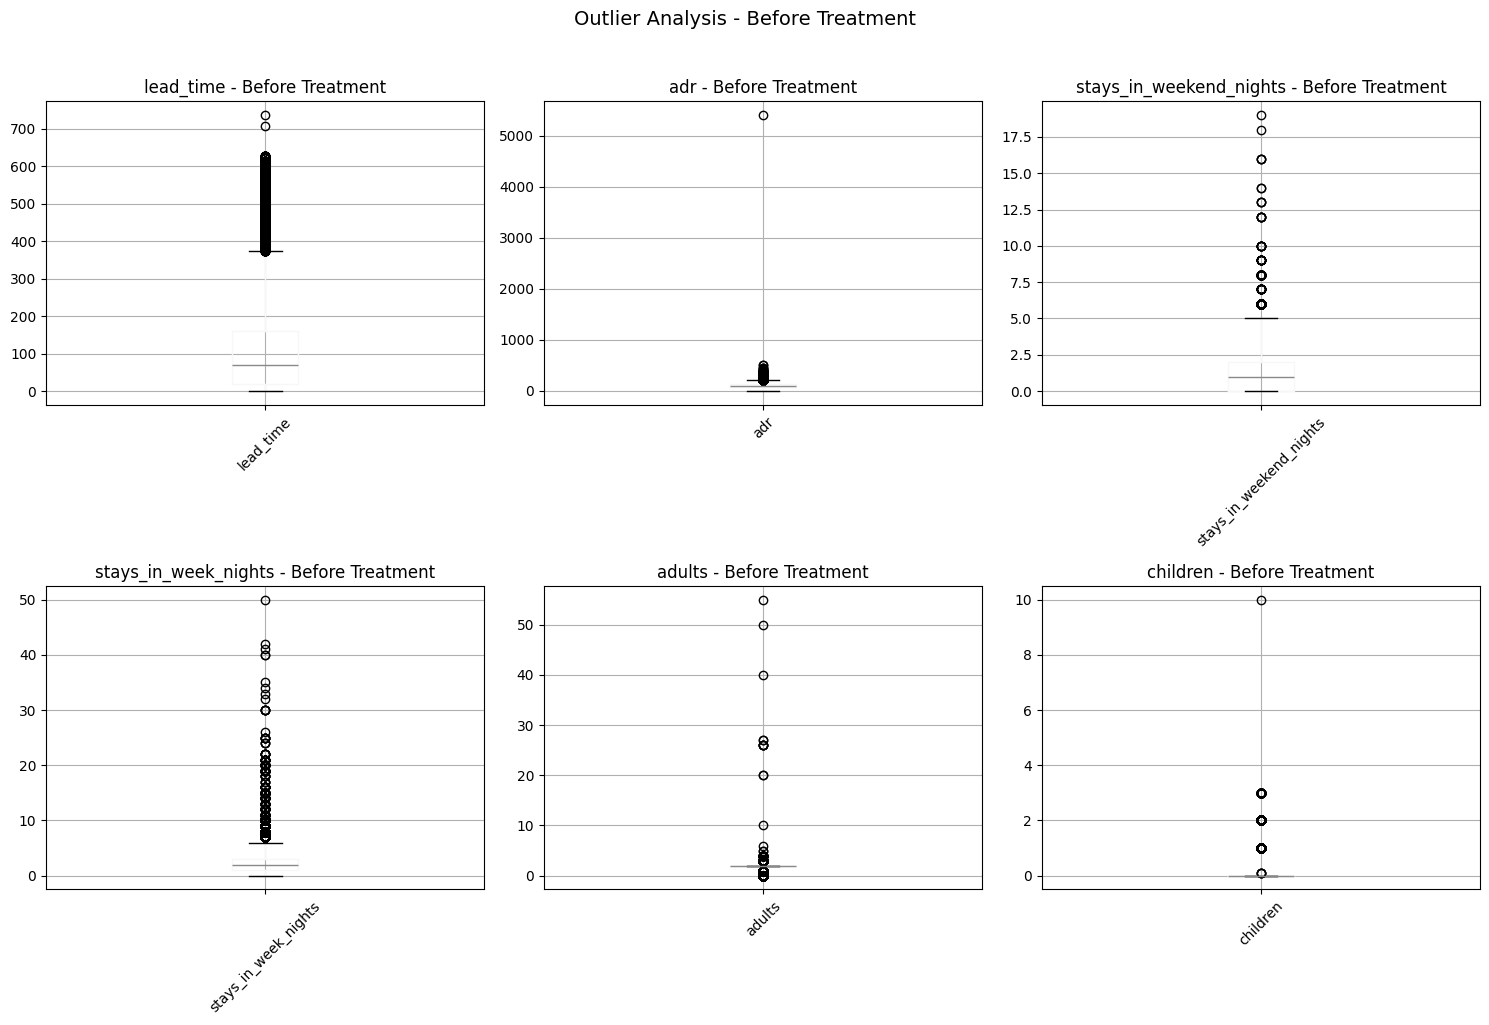

INFO:preprocessing:Handling outliers...
INFO:preprocessing:Capped 3005 outliers in lead_time
INFO:preprocessing:Capped 3793 outliers in adr
INFO:preprocessing:Capped 265 outliers in stays_in_weekend_nights
INFO:preprocessing:Capped 3354 outliers in stays_in_week_nights
INFO:preprocessing:Capped 3005 outliers in lead_time
INFO:preprocessing:Capped 3793 outliers in adr
INFO:preprocessing:Capped 265 outliers in stays_in_weekend_nights
INFO:preprocessing:Capped 3354 outliers in stays_in_week_nights
INFO:preprocessing:Total outliers capped: 10417
INFO:preprocessing:Total outliers capped: 10417


Shape maintained: (119390, 35) (no data loss)


In [58]:
# Key numerical columns for outlier analysis
numerical_cols = ['lead_time', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights', 
                 'adults', 'children', 'babies']
existing_cols = [col for col in numerical_cols if col in df_clean.columns]

# Visualize outliers before treatment
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(existing_cols[:6]):  # Show first 6 columns
    df_clean.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'{col} - Before Treatment')
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Outlier Analysis - Before Treatment', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Apply outlier treatment
df_outliers = preprocessor.detect_and_handle_outliers(df_clean)

print(f"Shape maintained: {df_outliers.shape} (no data loss)")

### Data Preparation & EDA Features
1. Remove data leakage columns (reservation_status)
2. Drop low-value columns (company, agent)
3. Encode categorical variables (Label Encoding)
4. Add EDA-based feature engineering

In [59]:
# Step 1: Prepare for modeling (remove leakage, encode categories)
df_prepared = preprocessor.prepare_for_modeling(df_outliers)

# Step 2: Add only basic derived features (moved complex features to separate notebook)
df_final = preprocessor.add_basic_derived_features(df_prepared)

print(f"\nFinal Dataset Summary:")
print(f"Shape: {df_final.shape[0]:,} rows × {df_final.shape[1]:,} columns")
print(f"Final cancellation rate: {df_final['is_canceled'].mean():.3f}")

# Show basic derived features
basic_features = ['total_stay_duration', 'total_guests']
existing_basic_features = [col for col in basic_features if col in df_final.columns]

if existing_basic_features:
    print(f"\n🔧 Basic Derived Features Added: {len(existing_basic_features)}")
    for feature in existing_basic_features:
        if feature in df_final.columns:
            print(f"  - {feature}: {df_final[feature].dtype}")

INFO:preprocessing:Preparing for modeling...
INFO:preprocessing:Removed leakage columns: ['reservation_status', 'reservation_status_date']
INFO:preprocessing:Removed leakage columns: ['reservation_status', 'reservation_status_date']
INFO:preprocessing:Removed low-value columns: ['agent']
INFO:preprocessing:Removed low-value columns: ['agent']
INFO:preprocessing:Encoded 9 categorical columns
INFO:preprocessing:Adding basic derived features...
INFO:preprocessing:Encoded 9 categorical columns
INFO:preprocessing:Adding basic derived features...
INFO:preprocessing:Added 2 basic features: ['total_stay_duration', 'total_guests']
INFO:preprocessing:Added 2 basic features: ['total_stay_duration', 'total_guests']



Final Dataset Summary:
Shape: 119,390 rows × 34 columns
Final cancellation rate: 0.370

🔧 Basic Derived Features Added: 2
  - total_stay_duration: int64
  - total_guests: float64


### Pipeline Results & Validation

**Compare Before vs After Preprocessing:**

In [60]:
# Pipeline Results & Validation
print("Essential Preprocessing Pipeline - Results Summary")
print("="*60)

# Before vs After comparison
original_shape = df.shape
final_shape = df_final.shape
processing_time = (datetime.now() - start_time).total_seconds()

comparison_data = {
    'Metric': ['Rows', 'Columns', 'Missing Values', 'Cancellation Rate', 'Memory (MB)'],
    'Before': [
        f"{original_shape[0]:,}",
        f"{original_shape[1]:,}",
        f"{df.isnull().sum().sum():,}",
        f"{df['is_canceled'].mean():.3f}",
        f"{df.memory_usage(deep=True).sum() / 1024**2:.2f}"
    ],
    'After': [
        f"{final_shape[0]:,}",
        f"{final_shape[1]:,}",
        f"{df_final.isnull().sum().sum():,}",
        f"{df_final['is_canceled'].mean():.3f}",
        f"{df_final.memory_usage(deep=True).sum() / 1024**2:.2f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"Ready for export to: data/processed/hotel_booking_preprocessed.csv")

# Data quality checks
print(f"\nFinal Quality Checks:")
print(f"✅ No missing values: {df_final.isnull().sum().sum() == 0}")
print(f"✅ No duplicate rows: {df_final.duplicated().sum() == 0}")
print(f"✅ Target preserved: {'is_canceled' in df_final.columns}")
print(f"✅ EDA features added: {len([col for col in ['total_stay_duration', 'is_family'] if col in df_final.columns])}/2 key features")

# Show final column types
numerical_final = len(df_final.select_dtypes(include=[np.number]).columns)
categorical_final = len(df_final.select_dtypes(include=['object']).columns)
print(f"\nFinal Column Distribution:")
print(f"Numerical: {numerical_final}, Categorical: {categorical_final}")
print(f"Total: {numerical_final + categorical_final} columns")

Essential Preprocessing Pipeline - Results Summary
           Metric  Before   After
             Rows 119,390 119,390
          Columns      36      34
   Missing Values 129,425       0
Cancellation Rate   0.370   0.370
      Memory (MB)  123.45   61.88
Ready for export to: data/processed/hotel_booking_preprocessed.csv

Final Quality Checks:
✅ No missing values: True
✅ No duplicate rows: True
✅ Target preserved: True
✅ EDA features added: 1/2 key features

Final Column Distribution:
Numerical: 29, Categorical: 5
Total: 34 columns
           Metric  Before   After
             Rows 119,390 119,390
          Columns      36      34
   Missing Values 129,425       0
Cancellation Rate   0.370   0.370
      Memory (MB)  123.45   61.88
Ready for export to: data/processed/hotel_booking_preprocessed.csv

Final Quality Checks:
✅ No missing values: True
✅ No duplicate rows: True
✅ Target preserved: True
✅ EDA features added: 1/2 key features

Final Column Distribution:
Numerical: 29, Categorica

### Export Processed Data

**Save cleaned dataset for model training:**

In [61]:
# Export preprocessed data for feature engineering phase
import os

# Ensure directories exist
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# Save preprocessed dataset (input for feature engineering)
output_file = '../data/processed/hotel_booking_preprocessed.csv'
df_final.to_csv(output_file, index=False)
print(f"Preprocessed data saved: {output_file}")
print(f"File size: {os.path.getsize(output_file) / 1024**2:.2f} MB")

# Pipeline completion message
print(f"  - Clean Data: {output_file}")

Preprocessed data saved: ../data/processed/hotel_booking_preprocessed.csv
File size: 16.30 MB
  - Clean Data: ../data/processed/hotel_booking_preprocessed.csv
